In [1]:
from importlib.metadata import version
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
import numpy as np

print("medmnist version: " + str(version("medmnist")))
print("matplotlib version: " + str(version("matplotlib")))
print("torch version: " + str(torch.__version__))
print("torchvision version: " + str(version("torchvision")))
print("PIL version: " + str(version("pillow")))
print("numpy version: " + str(np.__version__))

medmnist version: 3.0.2
matplotlib version: 3.10.8
torch version: 2.9.1
torchvision version: 0.24.1
PIL version: 12.1.0
numpy version: 2.4.1


## About the data

This project uses the **BreastMNIST** dataset from the [MedMNIST project](https://medmnist.com/), a curated benchmark collection of lightweight biomedical image datasets designed for machine learning research.

### Original data source

The breast ultrasound images were originally collected from clinical ultrasound examinations and compiled from publicly available medical imaging repositories used in prior academic studies on breast lesion classification. The raw images vary in:

- Spatial resolution
- Intensity scale
- Aspect ratio
- Acquisition devices and clinical settings

MedMNIST aggregates these sources and provides a standardized version suitable for machine learning benchmarking.

### Dataset composition

The BreastMNIST dataset contains:

- **780 grayscale breast ultrasound images**
- **2 classes**:
  - 0: normal / benign  
  - 1: malignant  

In this project, the **128×128 pixel version** of the dataset is used.

### Standardization and preprocessing by MedMNIST

MedMNIST applies the following preprocessing steps to all images:

1. Conversion to grayscale (single channel)
2. Center cropping or padding to preserve anatomical content
3. Resizing to fixed square resolutions (28×28, 64×64, 128×128, or 224×224)
4. Pixel intensity normalization to the range [0, 255]
5. Storage in NumPy-compatible format with predefined train, validation, and test splits

These steps ensure that all samples share the same shape and scale, enabling reproducible experiments and fair model comparison.

### How to download the dataset

The dataset is automatically downloaded using the official MedMNIST Python package:

```python
from medmnist import BreastMNIST

dataset = BreastMNIST(
    split = "train",
    size = 128,
    download = True
)
```

The files are cached locally after the first download.

References

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A large-scale lightweight benchmark for 2D and 3D biomedical image classification." _Scientific Data_, 2023.

Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis." _IEEE 18th International Symposium on Biomedical Imaging (ISBI)_, 2021.

In [2]:
# Project setup
# Set seeds for reproducibility
def set_seed(seed = 1601):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1601)

# Detect best device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Force CPU usage for deterministic results (comment out for faster non-deterministic training)
device = torch.device('cpu')

print(f"Using device: {device}")

# Mention object types to deal with pesky Pylance warnings:
train_loader: DataLoader
val_loader: DataLoader
test_loader: DataLoader

Using device: cpu


## Exploratory data analysis

In [3]:
# Use this code to download all the images in png format to the data folder
def save_medmnist_images(split_name):
    """Save MedMNIST images to data folder organized by split and label. The images are PIL objects."""
    # Load dataset
    dataset = BreastMNIST(split = split_name, download = True, size = 128)
  
    os.makedirs(f'../data/{split_name}/benign', exist_ok = True)
    os.makedirs(f'../data/{split_name}/malignant', exist_ok = True)

    # Save images
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        label_name = 'malignant' if label[0] == 1 else 'benign'
       
        # Save PIL objects at png files
        img.save(f'../data/{split_name}/{label_name}/img_{idx:04d}.png')
    
    print(f"Saved {len(dataset)} {split_name} images\n")

# Save all splits
save_medmnist_images('train')
save_medmnist_images('val')
save_medmnist_images('test')

Saved 546 train images

Saved 78 val images

Saved 156 test images



### Dataset statistics

In [4]:
def print_dataset_summary():
    """Print comprehensive dataset statistics"""
    print("=" * 40)
    print("BreastMNIST 128 x 128")
    print("=" * 40)
    
    splits = ['train', 'val', 'test']
    total_images = 0
    
    for split in splits:
        dataset = BreastMNIST(split = split, download = True, size = 128)
        img, label = dataset[0]
        
        # Convert to numpy array
        img_array = np.array(img)
        
        print(f"\n{split} set:")
        print(f"  Total images: {len(dataset)}")
        print(f"  Image shape: {img_array.shape}")
        print(f"  Image dtype: {img_array.dtype}")
        print(f"  Pixel range: [{img_array.min()}, {img_array.max()}]")
        
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        print(f"  benign: {benign} ({benign/len(dataset)*100:.1f}%)")
        print(f"  malignant: {malignant} ({malignant/len(dataset)*100:.1f}%)")
        
        total_images += len(dataset)
    
    print(f"\nTotal dataset size: {total_images} images")
    print("=" * 40)

print_dataset_summary()

BreastMNIST 128 x 128

train set:
  Total images: 546
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [12, 239]
  benign: 147 (26.9%)
  malignant: 399 (73.1%)

val set:
  Total images: 78
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [2, 219]
  benign: 21 (26.9%)
  malignant: 57 (73.1%)

test set:
  Total images: 156
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [1, 240]
  benign: 42 (26.9%)
  malignant: 114 (73.1%)

Total dataset size: 780 images


### Class distribution by split

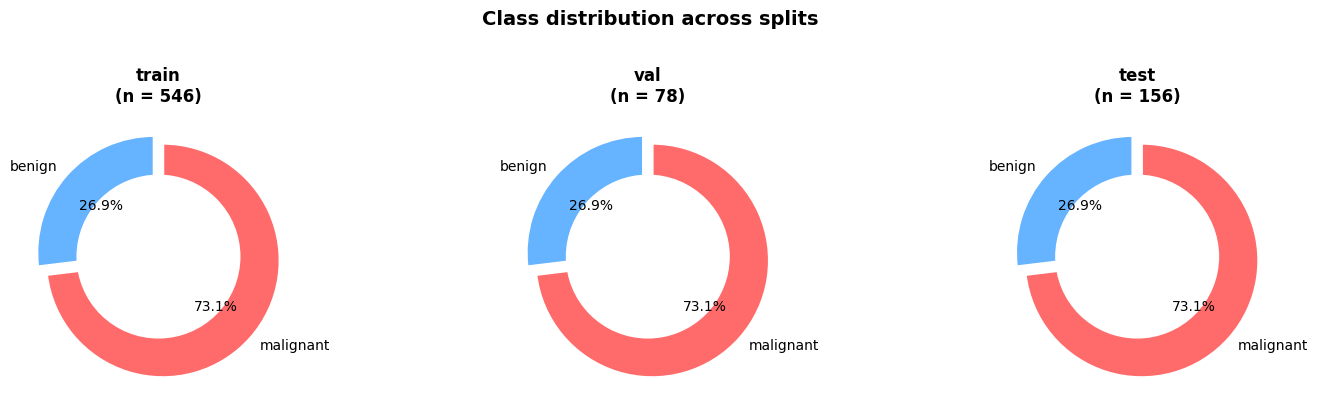


Class distribution summary:
--------------------------------------------------
train - benign: 147 (26.9%), malignant: 399 (73.1%)
val   - benign:  21 (26.9%), malignant:  57 (73.1%)
test  - benign:  42 (26.9%), malignant: 114 (73.1%)


In [5]:
def plot_class_distribution():
    """Plot class distribution across splits using donut charts"""
    splits = ['train', 'val', 'test']
    
    fig, axes = plt.subplots(1, 3, figsize = (15, 4))
    
    for idx, split in enumerate(splits):
        dataset = BreastMNIST(split = split, download = True, size = 128)
        
        # Count classes
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        
        # Create donut chart
        sizes = [benign, malignant]
        colors = ['#66b3ff', '#ff6b6b']
        explode = (0.05, 0.05)
        
        axes[idx].pie(sizes, explode = explode, labels = ['benign', 'malignant'], 
                     colors = colors, autopct = '%1.1f%%', startangle = 90,
                     wedgeprops={'edgecolor': 'white', 'linewidth': 2})
        
        # Draw circle for donut
        centre_circle = plt.Circle((0,0), 0.70, fc = 'white')
        axes[idx].add_artist(centre_circle)
        
        axes[idx].set_title(f'{split}\n(n = {len(dataset)})', fontsize = 12, fontweight = 'bold')
    
    fig.suptitle('Class distribution across splits', fontsize = 14, fontweight = 'bold', y = 1.02)
    fig.tight_layout()
    plt.show()
    
    # Print summary
    print("\nClass distribution summary:")
    print("-" * 50)
    for split in splits:
        dataset = BreastMNIST(split = split, download = True)
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        print(f"{split:5} - benign: {benign:3} ({benign/len(dataset)*100:.1f}%), "
              f"malignant: {malignant:3} ({malignant/len(dataset)*100:.1f}%)")

plot_class_distribution()

### Sample images

PIL size: (128, 128)
PIL Mode: L


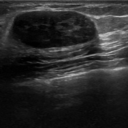

In [6]:
# Single sample
img = Image.open('../data/test/malignant/img_0001.png')

# PIL object size
print(f"PIL size: {img.size}")

# Get the mode (L = grayscale, RGB = color)
print(f"PIL Mode: {img.mode}")

img

In [7]:
# Array shape
img_array = np.array(img)

print(f"PIL as array shape: {img_array.shape}")

PIL as array shape: (128, 128)


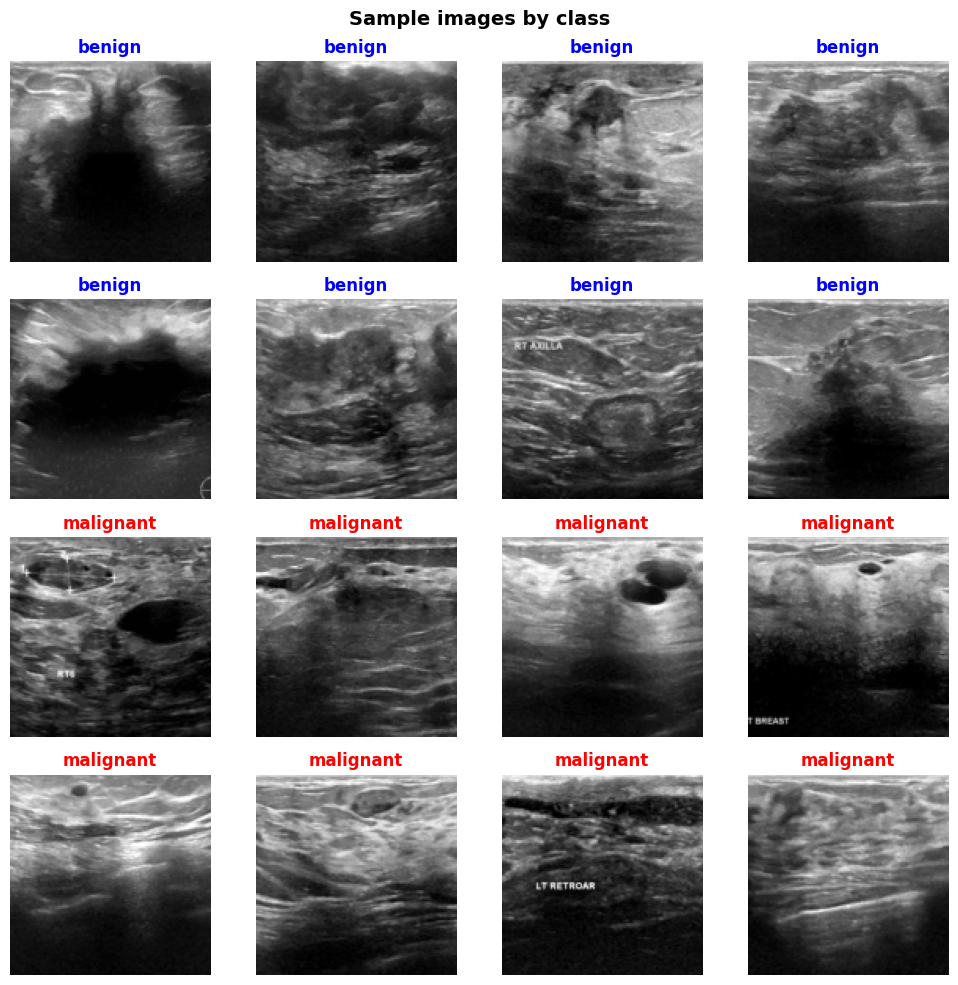

In [8]:
def plot_sample_images(n_samples = 16):
    """Display random sample of images from each class"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    # Get samples from each class
    benign_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1][0] == 0]
    malignant_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1][0] == 1]
    
    # Random samples
    np.random.seed(42)
    benign_samples = np.random.choice(benign_indices, n_samples//2, replace = False)
    malignant_samples = np.random.choice(malignant_indices, n_samples//2, replace = False)
    
    fig, axes = plt.subplots(4, 4, figsize = (10, 10))
    
    for idx, ax in enumerate(axes.flat):
        if idx < n_samples//2:
            img, _ = train_dataset[benign_samples[idx]]
            title = 'benign'
            color = 'blue'
        else:
            img, _ = train_dataset[malignant_samples[idx - n_samples//2]]
            title = 'malignant'
            color = 'red'
        
        ax.imshow(img, cmap = 'gray')
        ax.set_title(title, color = color, fontweight = 'bold')
        ax.axis('off')
    
    fig.suptitle('Sample images by class', fontsize = 14, fontweight = 'bold')
    fig.tight_layout()
    plt.show()

plot_sample_images()

### Intensity distribution

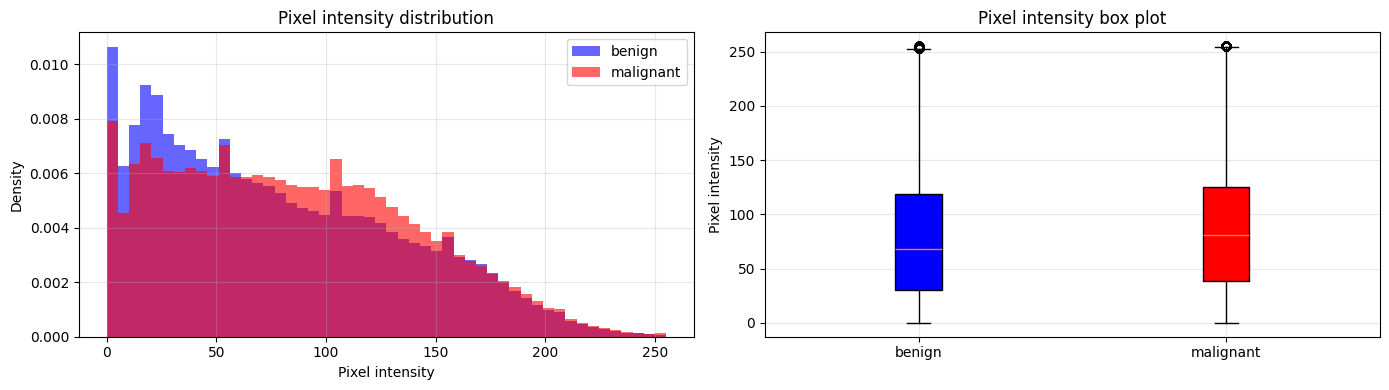


Pixel intensity statistics
--------------------------------------------------
benign    - mean: 78.19, std: 56.03
malignant - mean: 85.53, std: 54.96


In [9]:
def plot_pixel_intensity_distribution():
    """Compare pixel intensity distributions between classes"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    benign_pixels = []
    malignant_pixels = []
    
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        # Convert to numpy array first
        img_array = np.array(img)
        
        if label[0] == 0:
            benign_pixels.extend(img_array.flatten())
        else:
            malignant_pixels.extend(img_array.flatten())
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    
    # Histogram
    axes[0].hist(benign_pixels, bins = 50, alpha = 0.6, label = 'benign', color = 'blue', density = True)
    axes[0].hist(malignant_pixels, bins = 50, alpha = 0.6, label = 'malignant', color = 'red', density = True)
    axes[0].set_xlabel('Pixel intensity')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Pixel intensity distribution')
    axes[0].legend()
    axes[0].grid(alpha = 0.3)
    
    # Box plot
    data = [benign_pixels, malignant_pixels]
    bp = axes[1].boxplot(data, tick_labels = ['benign', 'malignant'], patch_artist = True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('red')
    axes[1].set_ylabel('Pixel intensity')
    axes[1].set_title('Pixel intensity box plot')
    axes[1].grid(alpha = 0.3)
    
    fig.tight_layout()
    plt.show()
    
    # Statistics
    print("\nPixel intensity statistics")
    print("-" * 50)
    print(f"benign    - mean: {np.mean(benign_pixels):.2f}, std: {np.std(benign_pixels):.2f}")
    print(f"malignant - mean: {np.mean(malignant_pixels):.2f}, std: {np.std(malignant_pixels):.2f}")

plot_pixel_intensity_distribution()

### Brightness comparison

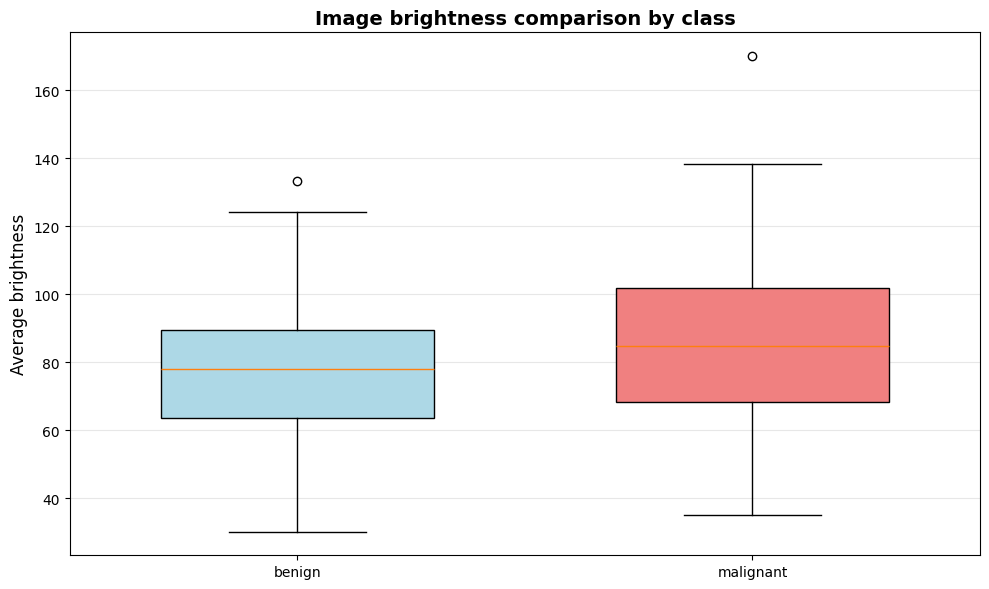


Brightness statistics:
benign    - mean: 78.19, std: 19.67
malignant - mean: 85.53, std: 21.92


In [10]:
def plot_brightness_comparison():
    """Compare average brightness between classes"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    benign_brightness = []
    malignant_brightness = []
    
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        # Convert to numpy array first
        img_array = np.array(img)
        brightness = np.mean(img_array)
        
        if label[0] == 0:
            benign_brightness.append(brightness)
        else:
            malignant_brightness.append(brightness)
    
    fig, ax = plt.subplots(figsize = (10, 6))
    
    positions = [1, 2]
    bp = ax.boxplot([benign_brightness, malignant_brightness], 
                     positions = positions,
                     widths = 0.6,
                     patch_artist = True,
                     tick_labels = ['benign', 'malignant'])
    
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel('Average brightness', fontsize = 12)
    ax.set_title('Image brightness comparison by class', fontsize = 14, fontweight = 'bold')
    ax.grid(axis = 'y', alpha = 0.3)
    
    fig.tight_layout()
    plt.show()
    
    print(f"\nBrightness statistics:")
    print(f"benign    - mean: {np.mean(benign_brightness):.2f}, std: {np.std(benign_brightness):.2f}")
    print(f"malignant - mean: {np.mean(malignant_brightness):.2f}, std: {np.std(malignant_brightness):.2f}")

plot_brightness_comparison()

## Data preprocessing

In [11]:
# Load and preprocess; converts to floating-point (0.0 to 1.0) and reshapes into (C, H, W) format
train_dataset = BreastMNIST(split = 'train', download = True, size = 128, transform = transforms.ToTensor())
val_dataset = BreastMNIST(split = 'val', download = True, size = 128, transform = transforms.ToTensor())
test_dataset = BreastMNIST(split = 'test', download = True, size = 128, transform = transforms.ToTensor())

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 546, Val: 78, Test: 156


In [12]:
# Look at raw values
train_dataset[0]

(tensor([[[0.6157, 0.6235, 0.6588,  ..., 0.6706, 0.6863, 0.6824],
          [0.6000, 0.6000, 0.6078,  ..., 0.6784, 0.6980, 0.7137],
          [0.7216, 0.6980, 0.6824,  ..., 0.7216, 0.7255, 0.7333],
          ...,
          [0.2745, 0.2980, 0.2902,  ..., 0.1490, 0.1490, 0.1451],
          [0.2196, 0.2196, 0.2549,  ..., 0.1686, 0.1412, 0.1333],
          [0.1882, 0.1725, 0.1882,  ..., 0.2078, 0.2078, 0.1804]]]),
 array([1]))

In [13]:
# Get one image, look at dimensions and size
img, label = train_dataset[0]

# Tensor shape
print(f"Tensor shape: {img.shape}")  # e.g., torch.Size([1, 28, 28])
print(f"Tensor dimensions: C = {img.shape[0]}, H = {img.shape[1]}, W = {img.shape[2]}")

# Memory size in bytes
print(f"Tensor memory: {img.element_size() * img.nelement()} bytes")

Tensor shape: torch.Size([1, 128, 128])
Tensor dimensions: C = 1, H = 128, W = 128
Tensor memory: 65536 bytes


In [14]:
# Create data loaders
def make_loaders():
    set_seed(1601)
    return (
        DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0),
        DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0),
        DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 0),
    )

## Convolutional neural network (CNN) setup

### Data flow and dimensions (128×128 images)

| Layer                 | Input dim      | Output dim     | Purpose/function                          |
| :---                  | :---           | :---           | :---                                      |
| **Input**             |  (1, 128, 128) |  (1, 128, 128) | Grayscale input image.                    |
| **Conv1 + BN + ReLU** |  (1, 128, 128) | (16, 128, 128) | Extracts basic patterns (edges/lines)     |
| **MaxPool1**          | (16, 128, 128) |   (16, 64, 64) | Reduce spatial resolution by half         |
| **Conv2 + BN + ReLU** |   (16, 64, 64) |   (32, 64, 64) | Learn more complex textures and shapes    |
| **MaxPool2**          |   (32, 64, 64) |   (32, 32, 32) | Reduces spatial size further              |
| **Conv Dropout**      |   (32, 32, 32) |   (32, 32, 32) | Regularize convolutional features         |
| **Conv3 + BN + ReLU** |   (32, 32, 32) |   (64, 32, 32) | Extract higher-level features             |
| **MaxPool3**          |   (64, 32, 32) |   (64, 16, 16) | Halves spatial dimensions                 |
| **Conv4 + BN + ReLU** |   (64, 16, 16) |  (128, 16, 16) | Extracts most complex features            |
| **MaxPool4**          |  (128, 16, 16) |    (128, 8, 8) | Final spatial reduction                   |
| **AdaptiveAvgPool**   |    (128, 8, 8) |    (128, 4, 4) | Convert feature maps to fixed size        |
| **Flatten**           |    (128, 4, 4) |           2048 | Convert feature maps into vector          |
| **FC Dropout**.       |           2048 |           2048 | Reduce overfitting                        |
| **Fully Connected**   |           2048 |              2 | Output class scores (benign vs malignant) |

In [15]:
# Create CNN model, allow conv and fc dropout rates to be set manually
class BreastCNN(nn.Module):
    def __init__(self, conv_drop_rate = 0.0, fc_drop_rate = 0.3):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        # Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)

        # Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)

        # Block 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Dropouts
        self.drop_conv = nn.Dropout2d(p = conv_drop_rate)
        self.drop_fc = nn.Dropout(p = fc_drop_rate)

        # Adaptive pooling for input-size independence
        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected
        self.fc = nn.Linear(128 * 4 * 4, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = self.drop_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.gap(x)

        x = x.view(x.size(0), -1)

        x = self.drop_fc(x)
        x = self.fc(x)

        return x

# Function to initialize model, loss, and optimizer
def setup_experiment(c_drop, f_drop, w_decay, lr = 1e-3):
    model = BreastCNN(conv_drop_rate = c_drop, fc_drop_rate = f_drop).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = w_decay)
    return model, criterion, optimizer

In [16]:
# Helper functions for training and validation
def run_epoch(model, loader, criterion, optimizer = None):
    # Switch mode depending on training or validation
    if optimizer:
        model.train()
    else:
        model.eval()
        
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Calculate gradients if training, do not if performing validation
    context = torch.enable_grad() if optimizer else torch.no_grad()
    
    with context:
        for inputs, labels in loader:
            # Moves images from RAM to processor, remove extra dimensions, ensure integers
            inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
            
            if optimizer:
                # Clear calculations
                optimizer.zero_grad()
            
            # Images go through CNN
            outputs = model(inputs)
            # Get logits
            loss = criterion(outputs, labels)
            
            if optimizer:
                # Calculate next step
                loss.backward()
                # Update weights
                optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [17]:
def train_model(model, optimizer, criterion, version_name, num_epochs = 30, use_scheduler = True):
    """
    Train a model and track metrics
    Best practices implemented:
    - Evaluate on test set at the very end
    - Track train/val metrics to diagnose overfitting
    - Save best model based on validation accuracy
    - Plot learning curves for quick diagnosis
    - Optional learning rate scheduler to reduce LR on plateau
    """
    best_val_acc = 0.0
    save_path = f"best_model_{version_name}.pth"
    
    # Lists to store metrics for plotting
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Initialize scheduler
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode = 'max', factor = 0.5, patience = 5
        )
    
    print(f"Training {version_name}...")
    print("-" * 62)
    
    for epoch in range(num_epochs):
        # Training and validation
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion)
        
        # Track metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Step scheduler based on validation accuracy
        if use_scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_acc)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"  Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")
        
        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            status = "✓ Saved"
        else:
            status = ""
        
        # Print epoch info
        print(f"Epoch {epoch+1:02d} | "
              f"Train: {train_acc:.1f}% ({train_loss:.4f}) | "
              f"Val: {val_acc:.1f}% ({val_loss:.4f}) {status}")
    
    print("-" * 62)
    
    # Summary statistics
    import numpy as np
    print(f"\nTraining summary for {version_name}:")
    print(f"  Best val accuracy: {best_val_acc:.2f}%")
    print(f"  Mean val loss: {np.mean(val_losses):.4f}")
    print(f"  Final train accuracy: {train_accs[-1]:.2f}%")
    print(f"  Std train loss: {np.std(train_losses):.4f}")
    
    # Plot training curves
    import matplotlib.pyplot as plt
    epochs_range = range(1, num_epochs + 1)
    
    plt.figure(figsize = (12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accs, 'b-', label = 'Train', linewidth = 2)
    plt.plot(epochs_range, val_accs, 'r-', label = 'Val', linewidth = 2)
    plt.xlabel('Epoch', fontsize = 11)
    plt.ylabel('Accuracy (%)', fontsize = 11)
    plt.title(f'{version_name} - Accuracy', fontsize = 12, fontweight = 'bold')
    plt.legend()
    plt.grid(True, alpha = 0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, 'b-', label = 'Train', linewidth = 2)
    plt.plot(epochs_range, val_losses, 'r-', label = 'Val', linewidth = 2)
    plt.xlabel('Epoch', fontsize = 11)
    plt.ylabel('Loss', fontsize = 11)
    plt.title(f'{version_name} - Loss', fontsize = 12, fontweight = 'bold')
    plt.legend()
    plt.grid(True, alpha = 0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Load best model and evaluate only on test set
    model.load_state_dict(torch.load(save_path))
    _, test_acc = run_epoch(model, test_loader, criterion)
    print(f"{'='*62}")
    print(f">> {version_name} test accuracy: {test_acc:.2f}%")
    print(f"{'='*62}\n")

## Model training

### Model 1

Training V1_Baseline...
--------------------------------------------------------------
Epoch 01 | Train: 71.2% (0.6779) | Val: 26.9% (1.0910) ✓ Saved
Epoch 02 | Train: 81.3% (0.4156) | Val: 30.8% (1.0171) ✓ Saved
Epoch 03 | Train: 85.7% (0.3811) | Val: 52.6% (0.7106) ✓ Saved
Epoch 04 | Train: 85.9% (0.3464) | Val: 80.8% (0.3880) ✓ Saved
Epoch 05 | Train: 88.5% (0.3351) | Val: 82.1% (0.3612) ✓ Saved
Epoch 06 | Train: 84.1% (0.3648) | Val: 84.6% (0.2572) ✓ Saved
Epoch 07 | Train: 85.7% (0.3108) | Val: 93.6% (0.2231) ✓ Saved
Epoch 08 | Train: 91.0% (0.2456) | Val: 89.7% (0.2411) 
Epoch 09 | Train: 85.5% (0.2663) | Val: 82.1% (0.6449) 
Epoch 10 | Train: 90.3% (0.2666) | Val: 88.5% (0.2163) 
Epoch 11 | Train: 91.0% (0.2225) | Val: 89.7% (0.2539) 
Epoch 12 | Train: 92.5% (0.1849) | Val: 91.0% (0.1790) 
Epoch 13 | Train: 95.4% (0.1359) | Val: 88.5% (0.2414) 
Epoch 14 | Train: 96.7% (0.1148) | Val: 92.3% (0.1796) 
Epoch 15 | Train: 97.6% (0.0982) | Val: 92.3% (0.1501) 
Epoch 16 | Train: 96.9% 

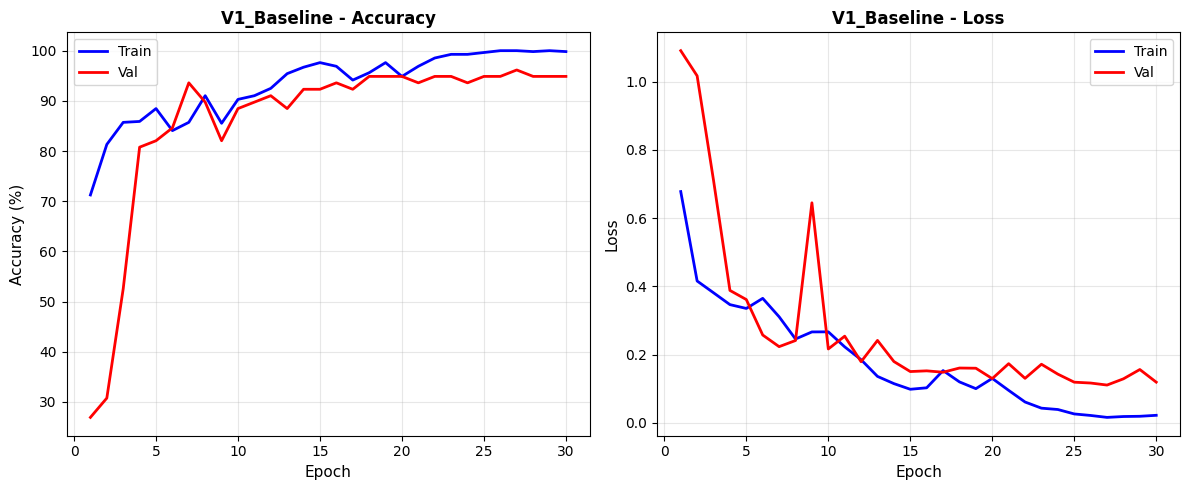

>> V1_Baseline test accuracy: 89.10%



In [18]:
# Version 1: fc dropout = 0.3, no conv dropout
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.3, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V1_Baseline", use_scheduler = False)

The model achieved 96.2% validation accuracy at epoch 27 and 89.1% on the test set, showing a 7-point gap that indicates moderate overfitting. Training was relatively stable in the first half but the model clearly memorized the training data in later epochs, reaching 100% training accuracy by epoch 26 while validation plateaued around 95%. The model continued training for 3 epochs past the best validation checkpoint without improvement. Despite the overfitting, the 89.1% test performance is reasonable and validates that the model generalized better than the val-test gap suggests. The next version will increase regularization to prevent the training accuracy from hitting 100% and potentially improve test performance.

### Number of parameters

In [19]:
# These will be the same for all subsequent models as well (architecture will be the same)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total trainable parameters:", count_parameters(model))

print("\nParameters by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name:30s} {param.numel():>10}")

Total trainable parameters: 101730

Parameters by layer:
conv1.weight                          144
conv1.bias                             16
bn1.weight                             16
bn1.bias                               16
conv2.weight                         4608
conv2.bias                             32
bn2.weight                             32
bn2.bias                               32
conv3.weight                        18432
conv3.bias                             64
bn3.weight                             64
bn3.bias                               64
conv4.weight                        73728
conv4.bias                            128
bn4.weight                            128
bn4.bias                              128
fc.weight                            4096
fc.bias                                 2


### Model 2

Training V2_Stronger_FC...
--------------------------------------------------------------
Epoch 01 | Train: 72.9% (0.7002) | Val: 26.9% (1.2041) ✓ Saved
Epoch 02 | Train: 79.3% (0.4462) | Val: 30.8% (1.0125) ✓ Saved
Epoch 03 | Train: 83.5% (0.4184) | Val: 57.7% (0.6600) ✓ Saved
Epoch 04 | Train: 83.7% (0.3804) | Val: 80.8% (0.4061) ✓ Saved
Epoch 05 | Train: 85.2% (0.3914) | Val: 74.4% (0.5290) 
Epoch 06 | Train: 84.4% (0.3619) | Val: 88.5% (0.2617) ✓ Saved
Epoch 07 | Train: 86.3% (0.3143) | Val: 88.5% (0.2518) 
Epoch 08 | Train: 88.6% (0.2656) | Val: 87.2% (0.3195) 
Epoch 09 | Train: 85.3% (0.3094) | Val: 76.9% (0.8420) 
Epoch 10 | Train: 87.4% (0.3738) | Val: 89.7% (0.2444) ✓ Saved
Epoch 11 | Train: 85.7% (0.3148) | Val: 91.0% (0.1970) ✓ Saved
Epoch 12 | Train: 89.4% (0.2873) | Val: 84.6% (0.3042) 
Epoch 13 | Train: 90.5% (0.2110) | Val: 87.2% (0.2822) 
Epoch 14 | Train: 92.3% (0.1972) | Val: 93.6% (0.1978) ✓ Saved
Epoch 15 | Train: 92.7% (0.1869) | Val: 89.7% (0.1938) 
Epoch 16 | Tra

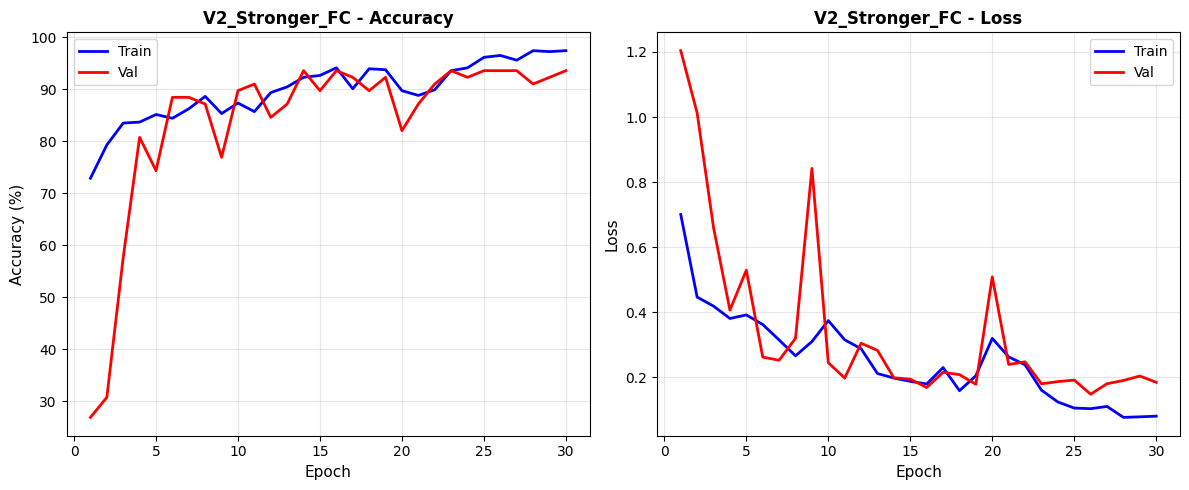

>> V2_Stronger_FC test accuracy: 85.90%



In [20]:
# Version 2: increase final dropout to stop high training accuracy
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.5, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V2_Stronger_FC", use_scheduler = False)

The model achieved 93.6% validation accuracy at epoch 14 and 85.9% on the test set, showing that increased FC dropout (0.5 vs 0.3) prevented extreme overfitting but significantly hurt test performance compared to V1 (89.1% → 85.9%). Training was more stable with the model reaching 97.4% final training accuracy instead of 100%, and the training loss variance decreased slightly (std: 0.14 vs 0.15). However, the validation accuracy also dropped from V1's 96.2% to 93.6%, and more critically, the validation-test gap widened from 7 points to 7.7 points, suggesting the stronger dropout is preventing the model from learning useful generalizable features. The regularization appears too aggressive for this task. The next version will try a middle ground with FC dropout of 0.4 to balance V1's strong generalization with V2's improved training stability.

### Model 3

Training V3_Medium_FC...
--------------------------------------------------------------
Epoch 01 | Train: 71.2% (0.6920) | Val: 26.9% (1.1302) ✓ Saved
Epoch 02 | Train: 79.7% (0.4330) | Val: 30.8% (0.9833) ✓ Saved
Epoch 03 | Train: 83.3% (0.4282) | Val: 64.1% (0.5750) ✓ Saved
Epoch 04 | Train: 83.3% (0.3796) | Val: 76.9% (0.4095) ✓ Saved
Epoch 05 | Train: 85.7% (0.3675) | Val: 82.1% (0.4346) ✓ Saved
Epoch 06 | Train: 87.2% (0.3348) | Val: 79.5% (0.3288) 
Epoch 07 | Train: 84.2% (0.3178) | Val: 91.0% (0.2668) ✓ Saved
Epoch 08 | Train: 88.5% (0.2657) | Val: 89.7% (0.2428) 
Epoch 09 | Train: 85.3% (0.2906) | Val: 78.2% (0.8382) 
Epoch 10 | Train: 87.2% (0.3096) | Val: 92.3% (0.2178) ✓ Saved
Epoch 11 | Train: 85.5% (0.2995) | Val: 88.5% (0.2297) 
Epoch 12 | Train: 89.4% (0.2545) | Val: 89.7% (0.2553) 
Epoch 13 | Train: 92.7% (0.1863) | Val: 89.7% (0.2023) 
Epoch 14 | Train: 94.1% (0.1625) | Val: 93.6% (0.1859) ✓ Saved
Epoch 15 | Train: 95.1% (0.1361) | Val: 92.3% (0.1650) 
Epoch 16 | Train

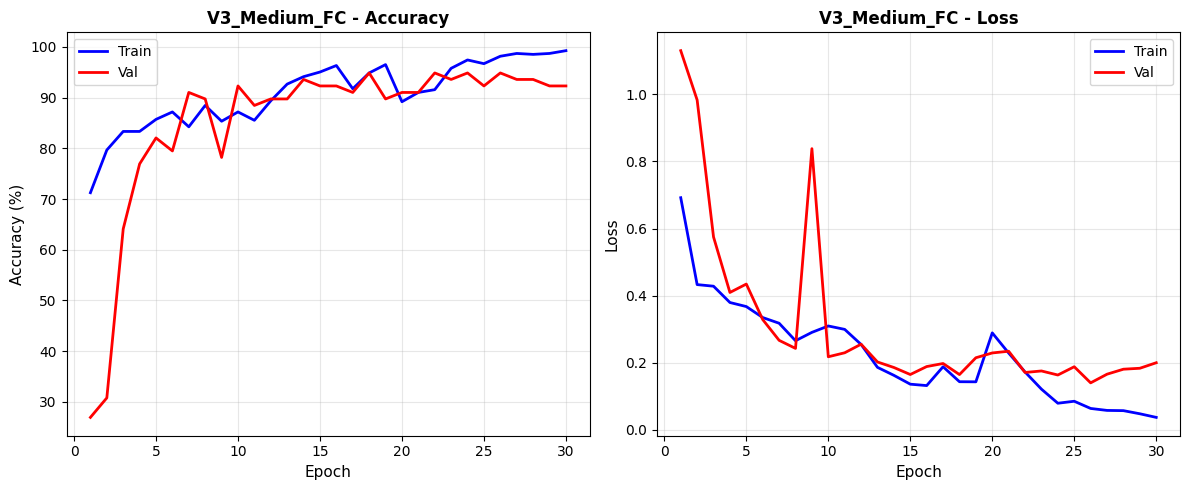

>> V3_Medium_FC test accuracy: 85.90%



In [21]:
# Version 3: add internal conv dropout to stop the CNN from memorizing shapes
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.4, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V3_Medium_FC", use_scheduler = False)

The model achieved 94.9% validation accuracy at epoch 18 and 85.9% on the test set, matching V2's test performance despite using FC dropout of 0.4 (midway between V1's 0.3 and V2's 0.5). The model still overfit significantly, reaching 99.3% training accuracy by epoch 30, nearly matching V1's extreme overfitting. Training stability was similar to previous versions (std train loss: 0.15), and the validation-test gap remains around 9 points. The FC dropout of 0.4 provided no benefit over 0.5, suggesting that FC dropout alone isn't solving the core problem. The overfitting appears to be happening in the convolutional layers where the model memorizes visual patterns, not just in the fully connected layers. The next version should return FC dropout to 0.3 (what worked best in V1) and add convolutional dropout (e.g., 0.1 or 0.2) to regularize the feature extraction layers where the memorization is likely occurring.

### Model 4

Training V4_Add_Conv...
--------------------------------------------------------------
Epoch 01 | Train: 72.5% (0.6685) | Val: 26.9% (0.9803) ✓ Saved
Epoch 02 | Train: 79.9% (0.5267) | Val: 34.6% (0.8251) ✓ Saved
Epoch 03 | Train: 81.5% (0.4956) | Val: 59.0% (0.6820) ✓ Saved
Epoch 04 | Train: 74.9% (0.5272) | Val: 73.1% (0.4894) ✓ Saved
Epoch 05 | Train: 85.2% (0.3836) | Val: 79.5% (0.3678) ✓ Saved
Epoch 06 | Train: 85.7% (0.3444) | Val: 83.3% (0.2954) ✓ Saved
Epoch 07 | Train: 85.0% (0.4198) | Val: 75.6% (0.4155) 
Epoch 08 | Train: 78.8% (0.4968) | Val: 80.8% (0.4138) 
Epoch 09 | Train: 84.4% (0.3553) | Val: 88.5% (0.2866) ✓ Saved
Epoch 10 | Train: 87.2% (0.2974) | Val: 80.8% (0.4197) 
Epoch 11 | Train: 87.4% (0.2879) | Val: 96.2% (0.2098) ✓ Saved
Epoch 12 | Train: 91.6% (0.2295) | Val: 88.5% (0.2317) 
Epoch 13 | Train: 91.4% (0.2099) | Val: 92.3% (0.2321) 
Epoch 14 | Train: 94.5% (0.1827) | Val: 92.3% (0.1985) 
Epoch 15 | Train: 94.5% (0.1629) | Val: 92.3% (0.1879) 
Epoch 16 | Train:

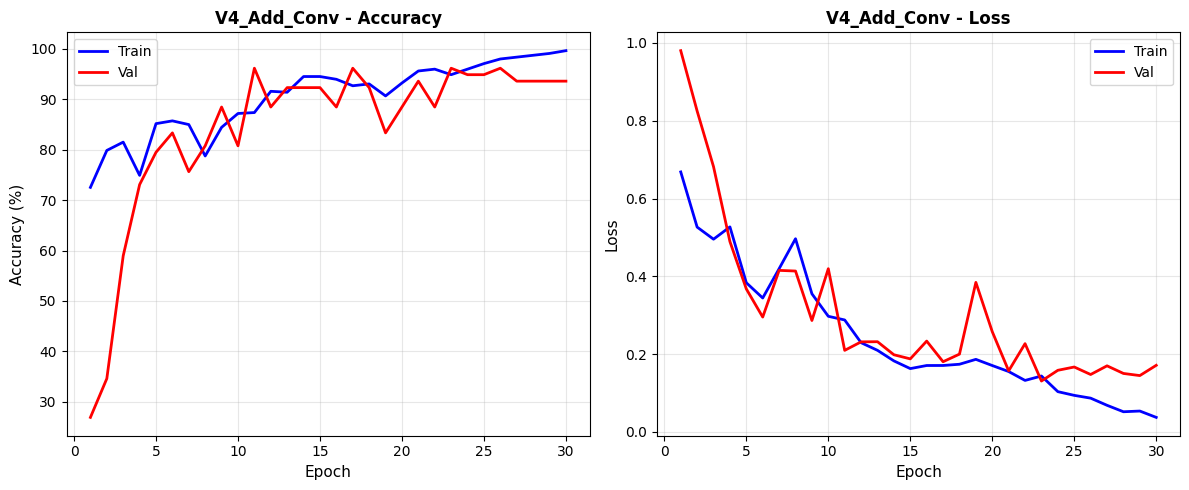

>> V4_Add_Conv test accuracy: 87.18%



In [22]:
# Version 4: add conv dropout
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.1, f_drop = 0.3, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V4_Add_Conv", use_scheduler = False)

The model achieved 96.2% validation accuracy at epoch 11 and 87.2% on the test set, showing slight improvement over V2 and V3 (85.9%) but still underperforming V1 (89.1%). Adding convolutional dropout (0.1) didn't prevent overfitting as the model still reached 99.6% training accuracy, nearly identical to V1's 100%. Training was actually less stable with higher variance (std train loss: 0.17 vs 0.15 in V1), and validation accuracy showed notable fluctuations (jumping from 80.8% at epoch 10 to 96.2% at epoch 11). The conv dropout appears to hurt more than help, likely disrupting feature learning in the early layers without addressing the core overfitting issue. Since V1 remains the best performer and the problem seems to be continued training after the optimal point rather than lack of regularization, the next approach should focus on stopping training at the right time.

### Model 5

Training V5_Scheduler...
--------------------------------------------------------------
Epoch 01 | Train: 71.2% (0.6779) | Val: 26.9% (1.0910) ✓ Saved
Epoch 02 | Train: 81.3% (0.4156) | Val: 30.8% (1.0171) ✓ Saved
Epoch 03 | Train: 85.7% (0.3811) | Val: 52.6% (0.7106) ✓ Saved
Epoch 04 | Train: 85.9% (0.3464) | Val: 80.8% (0.3880) ✓ Saved
Epoch 05 | Train: 88.5% (0.3351) | Val: 82.1% (0.3612) ✓ Saved
Epoch 06 | Train: 84.1% (0.3648) | Val: 84.6% (0.2572) ✓ Saved
Epoch 07 | Train: 85.7% (0.3108) | Val: 93.6% (0.2231) ✓ Saved
Epoch 08 | Train: 91.0% (0.2456) | Val: 89.7% (0.2411) 
Epoch 09 | Train: 85.5% (0.2663) | Val: 82.1% (0.6449) 
Epoch 10 | Train: 90.3% (0.2666) | Val: 88.5% (0.2163) 
Epoch 11 | Train: 91.0% (0.2225) | Val: 89.7% (0.2539) 
Epoch 12 | Train: 92.5% (0.1849) | Val: 91.0% (0.1790) 
  Learning rate reduced: 1.00e-03 -> 5.00e-04
Epoch 13 | Train: 95.4% (0.1359) | Val: 88.5% (0.2414) 
Epoch 14 | Train: 97.1% (0.1074) | Val: 94.9% (0.1449) ✓ Saved
Epoch 15 | Train: 98.2% (0

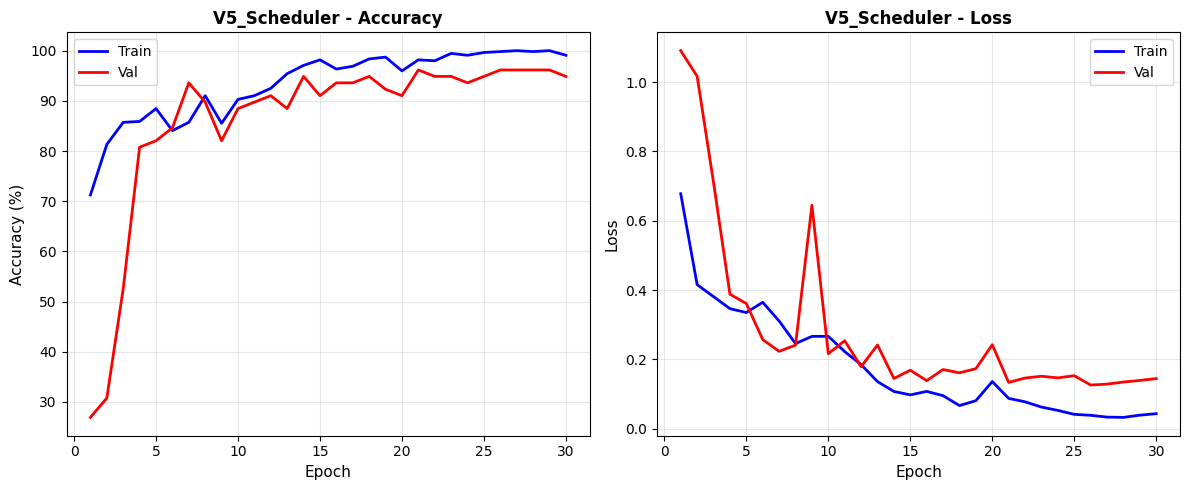

>> V5_Scheduler test accuracy: 87.82%



In [23]:
# Version 5: add scheduler
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.3, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V5_Scheduler", use_scheduler = True)

The model achieved 96.2% validation accuracy at epoch 21 and 87.8% on the test set, showing worse performance than V1. The scheduler reduced the learning rate three times (epochs 12, 19, and 26) but this didn't prevent overfitting as training accuracy still reached 100% by epoch 27. The scheduler helped the model continue improving validation accuracy in later epochs (hitting 96.2% again at epoch 21 vs epoch 27 in V1), but the test performance is still 1.3 points worse than V1's 89.1%. The val-test gap of 8.4 points suggests the model is still overfitting to the validation set despite the adaptive learning rate. Since regularization tweaks and scheduling haven't improved on V1's performance, the issue could be lack of training data diversity rather than optimization or regularization settings.

### Data augumentation

In [24]:
# Training transform with augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 10),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
])

# Validation/test transform without augmentation
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets with appropriate transforms
train_dataset = BreastMNIST(split = 'train', download = True, size = 128, transform = train_transform)
val_dataset = BreastMNIST(split = 'val', download = True, size = 128, transform = val_test_transform)
test_dataset = BreastMNIST(split = 'test', download = True, size = 128, transform = val_test_transform)

### Model 6

Training V6_Augmentation...
--------------------------------------------------------------
Epoch 01 | Train: 70.7% (0.6721) | Val: 26.9% (0.9277) ✓ Saved
Epoch 02 | Train: 74.0% (0.5570) | Val: 33.3% (1.1659) ✓ Saved
Epoch 03 | Train: 73.6% (0.5361) | Val: 71.8% (0.5508) ✓ Saved
Epoch 04 | Train: 74.5% (0.5802) | Val: 82.1% (0.3751) ✓ Saved
Epoch 05 | Train: 76.0% (0.5270) | Val: 83.3% (0.3754) ✓ Saved
Epoch 06 | Train: 73.8% (0.5314) | Val: 71.8% (0.6868) 
Epoch 07 | Train: 77.7% (0.6091) | Val: 89.7% (0.3584) ✓ Saved
Epoch 08 | Train: 75.5% (0.5612) | Val: 80.8% (0.3893) 
Epoch 09 | Train: 75.1% (0.5286) | Val: 85.9% (0.3824) 
Epoch 10 | Train: 74.7% (0.5627) | Val: 73.1% (0.5496) 
Epoch 11 | Train: 75.6% (0.5418) | Val: 82.1% (0.4205) 
Epoch 12 | Train: 76.9% (0.5159) | Val: 87.2% (0.3683) 
Epoch 13 | Train: 77.8% (0.5065) | Val: 83.3% (0.4221) 
Epoch 14 | Train: 80.4% (0.4711) | Val: 84.6% (0.4129) 
Epoch 15 | Train: 78.2% (0.4840) | Val: 85.9% (0.3631) 
Epoch 16 | Train: 80.4% (0.

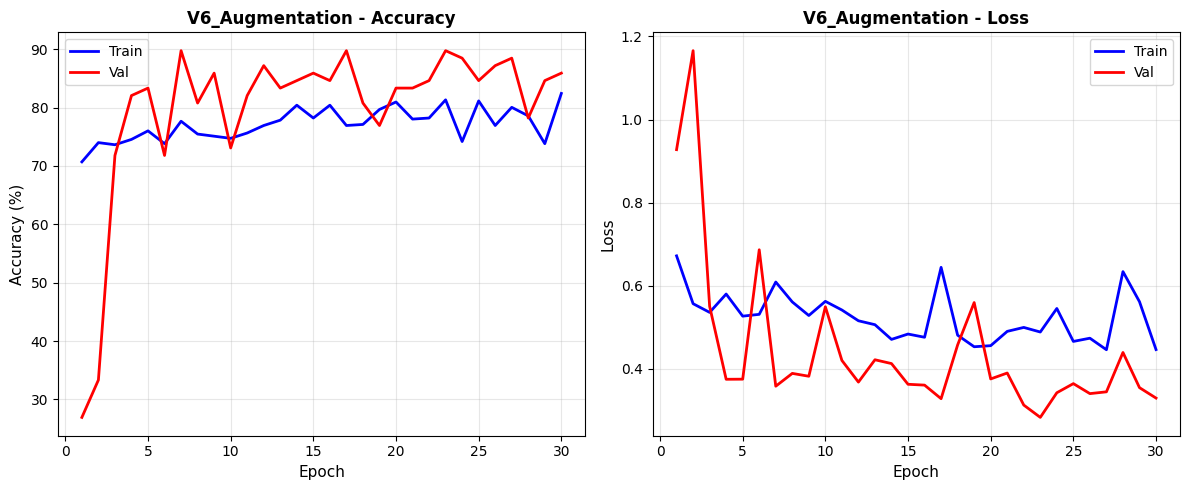

>> V6_Augmentation test accuracy: 81.41%



In [25]:
# Version 6: add data augmentation
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.3, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V6_Augmentation", use_scheduler = False)

The model achieved 89.7% validation accuracy at epoch 7 and only 81.4% on the test set, the worst performance yet. Data augmentation severely hurt the model, with training accuracy stuck around 75-82% (vs 100% in V1) and validation accuracy dropping from V1's 96.2% to 89.7%. The augmentation is too aggressive for this small dataset, preventing the model from learning the actual diagnostic features in the images. Training variance decreased significantly (std: 0.06 vs 0.15), but this is because the model is underfitting rather than learning stably. The heavy augmentation (horizontal flip, vertical flip, rotation, and translation combined) is creating too many distorted versions of the limited training data, making it harder for the model to identify the actual patterns that distinguish malignant from benign tissue.

## Results

### Final results comparison

| Version          | Conv dropout | FC dropout | Weight decay | Scheduler | Augmentation | Train acc (final %) | Val acc (peak %) | Test acc (%) | Notes |
|------------------|--------------|------------|--------------|-----------|--------------|---------------------|------------------|--------------|-------|
| V1_Baseline      |          0.0 |        0.3 |         1e-4 |        No |           No |                99.8 |             96.2 |         89.1 | Best test accuracy, extreme overfitting with 100% train acc |
| V2_Stronger_FC   |          0.0 |        0.5 |         1e-4 |        No |           No |                97.4 |             93.6 |         85.9 | Increased FC dropout reduced overfitting but hurt generalization |
| V3_Medium_FC     |          0.0 |        0.4 |         1e-4 |        No |           No |                99.3 |             94.9 |         85.9 | Middle-ground FC dropout, still overfit with no improvement |
| V4_Add_Conv      |          0.1 |        0.3 |         1e-4 |        No |           No |                99.6 |             96.2 |         87.2 | Conv dropout added, slight test improvement but still severe overfitting |
| V5_Scheduler     |          0.0 |        0.3 |         1e-4 |       Yes |           No |                99.1 |             96.2 |         87.8 | Scheduler improved test slightly, reduced LR 3 times during training |
| V6_Augmentation  |          0.0 |        0.3 |         1e-4 |        No |          Yes |                82.4 |             89.7 |         81.4 | Heavy augmentation caused severe underfitting, worst performance |

Summary:
V1_Baseline achieved the best test accuracy at 89.1% despite extreme overfitting (99.8% training accuracy), while all subsequent regularization attempts failed to improve generalization. Increasing FC dropout from 0.3 to 0.5 (V2) and trying intermediate values (V3 at 0.4) both reduced test performance to 85.9%, suggesting that stronger FC regularization prevented the model from learning useful features rather than reducing harmful overfitting. Adding convolutional dropout (V4) and implementing a learning rate scheduler (V5) provided modest improvements to 87.2% and 87.8% respectively, but neither approached V1's performance. The scheduler reduced the learning rate three times during training and showed the most promise as a refinement strategy, though the 7-8 point validation-test gap persisted across V1, V4, and V5.

Data augmentation (V6) with horizontal flips, vertical flips, rotations, and translations severely underfit the model, achieving only 81.4% test accuracy with training accuracy stuck at 82.4%. The aggressive augmentation transformations likely distorted diagnostic features critical for distinguishing malignant from benign tissue in this small medical imaging dataset. The consistently large validation-test gap across all models (7-10 points) suggests either the validation set is not representative of the test distribution or the dataset size fundamentally limits generalization. V1's simple configuration (FC dropout 0.3, weight decay 1e-4, no conv dropout, no scheduler, no augmentation) proved most effective, indicating that for this architecture and dataset, minimal regularization with early stopping around the validation peak would be the optimal approach.

Final chosen model: Model 1
